In [1]:
import h5py
import os
import sys
import tensorflow as tf
import numpy as np
from bm3d import bm3d_rgb, BM3DProfile
module_dir = "/global/u2/k/kberard/SCGSR/Research/Diamond/stock_models/bm3d-4.0.3/bm3d-4.0.3/examples" 
sys.path.insert(0, module_dir)
from experiment_funcs import get_experiment_noise, get_psnr, get_cropped_psnr
from PIL import Image
import matplotlib.pyplot as plt


2025-08-05 09:33:45.342481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754411625.355914   94742 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754411625.360037   94742 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754411625.371922   94742 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754411625.371934   94742 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754411625.371936   94742 computation_placer.cc:177] computation placer alr

In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
from thop import profile
from einops import rearrange 
from einops.layers.torch import Rearrange, Reduce
from timm.models.layers import trunc_normal_, DropPath

/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
print("here")

here


In [ ]:
#image denoise methods to try
#arciteture only 2024 https://www.nature.com/articles/s41598-024-60139-x
# cascaded gaze 2019 https://github.com/Ascend-Research/CascadedGaze
# SwinIR 2021 https://github.com/JingyunLiang/SwinIR?tab=readme-ov-file
#scunet, ffdnet (compared in nature paper, very close to nat perf) or dnCNN  toolbox with many models https://github.com/cszn/KAIR
#scunet it python based 
# https://pypi.org/project/bm3d/ Bm3d also in nature paper

In [4]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [5]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [5]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 1000
num_val = 100
num_test = 10

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")



KeyboardInterrupt

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f49654cbf20>>
Traceback (most recent call last):
  File "/global/u2/k/kberard/environments/SCGSR/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [7]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [8]:
print(ref_d.shape)

(64, 64, 64)


In [9]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


In [6]:
import numpy as np
import os

def encode_voxel_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                        y_train_3d, y_val_3d, y_test_3d,
                        ref_d=None, save_dir='scalers'):
    """
    Encode a batch of 3D volumes by normalizing each depth slice independently and replicating to RGB.
    Each input of shape (N, 64, 64, 64) is transformed into (N*64, 64, 64, 3).

    Args:
        *_3d: ndarray of shape (N, 64, 64, 64)
        ref_d: optional ndarray of shape (64, 64, 64)
        save_dir: directory to save the (min, max) scalers for each batch

    Returns:
        Tuple of:
            x_train_rgb, x_val_rgb, x_test_rgb,
            y_train_rgb, y_val_rgb, y_test_rgb,
            ref_d_rgb (or None if not provided)
    """
    os.makedirs(save_dir, exist_ok=True)

    def process_batch(batch, tag):
        N, D, H, W = batch.shape  # (N, 64, 64, 64)
        rgb_batch = np.zeros((N * D, H, W, 3), dtype=np.float32)
        all_mins = []
        all_maxs = []

        for i in range(N):
            mins = []
            maxs = []
            for d in range(D):
                slice_2d = batch[i, d, :, :]
                s_min = float(slice_2d.min())
                s_max = float(slice_2d.max())

                if s_max == s_min:
                    s_max = s_min + 1e-6  # prevent divide-by-zero

                normed = (slice_2d - s_min) / (s_max - s_min)
                rgb = np.stack([normed] * 3, axis=-1)  # shape: (64, 64, 3)

                rgb_batch[i * D + d] = rgb
                mins.append(s_min)
                maxs.append(s_max)

            all_mins.append(mins)
            all_maxs.append(maxs)

        np.savez(os.path.join(save_dir, f'{tag}_scalers.npz'),
                 mins=np.array(all_mins), maxs=np.array(all_maxs))

        return rgb_batch

    x_train_rgb = process_batch(x_train_3d, 'x_train')
    x_val_rgb   = process_batch(x_val_3d, 'x_val')
    x_test_rgb  = process_batch(x_test_3d, 'x_test')
    y_train_rgb = process_batch(y_train_3d, 'y_train')
    y_val_rgb   = process_batch(y_val_3d, 'y_val')
    y_test_rgb  = process_batch(y_test_3d, 'y_test')

    # Optional: single ref volume
    ref_d_rgb = None
    if ref_d is not None:
        ref_rgb = np.zeros((64, 64, 64, 3), dtype=np.float32)
        ref_mins = []
        ref_maxs = []
        for d in range(64):
            slice_2d = ref_d[d, :, :]
            s_min = float(slice_2d.min())
            s_max = float(slice_2d.max())

            if s_max == s_min:
                s_max = s_min + 1e-6

            normed = (slice_2d - s_min) / (s_max - s_min)
            ref_rgb[d] = np.stack([normed] * 3, axis=-1)
            ref_mins.append(s_min)
            ref_maxs.append(s_max)

        np.savez(os.path.join(save_dir, 'ref_d_scalers.npz'),
                 mins=np.array(ref_mins), maxs=np.array(ref_maxs))
        ref_d_rgb = ref_rgb

    return (
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb,
        ref_d_rgb
    )


ERROR! Session/line number was not unique in database. History logging moved to new session 760


In [7]:
import numpy as np

def decode_rgb_to_voxel_batch(rgb_data, scaler_path):
    """
    Decode RGB-encoded batch (N*64, 64, 64, 3) back to original (N, 64, 64, 64) data
    using per-slice min/max scalers.

    Args:
        rgb_data: ndarray of shape (N*64, 64, 64, 3)
        scaler_path: path to `.npz` file containing 'mins' and 'maxs' arrays
                     of shape (N, 64)

    Returns:
        reconstructed: ndarray of shape (N, 64, 64, 64)
    """
    num_slices = 64
    assert rgb_data.ndim == 4 and rgb_data.shape[1:4] == (64, 64, 3), \
        f"Expected shape (N*64, 64, 64, 3), got {rgb_data.shape}"

    N = rgb_data.shape[0] // num_slices
    assert rgb_data.shape[0] == N * num_slices, "RGB data is not a multiple of 64 slices"

    scalers = np.load(scaler_path)
    mins = scalers['mins']  # shape (N, 64)
    maxs = scalers['maxs']  # shape (N, 64)

    reconstructed = np.zeros((N, 64, 64, 64), dtype=np.float32)

    for i in range(N):
        for d in range(num_slices):
            idx = i * num_slices + d
            normed = rgb_data[idx, :, :, 0]  # Use first channel (R), they are all the same
            s_min = mins[i, d]
            s_max = maxs[i, d]
            reconstructed[i, d, :, :] = normed * (s_max - s_min) + s_min

    return reconstructed


In [12]:
x_train_rgb, x_val_rgb, x_test_rgb, \
y_train_rgb, y_val_rgb, y_test_rgb, \
ref_d_rgb = encode_voxel_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    ref_d=ref_d
)
print("done generating")

done generating


In [13]:
# Encode first
#x_train_rgb = encode_voxel_to_rgb(x_train, x_val, x_test, y_train, y_val, y_test)[0]


x_train_reconstructed = decode_rgb_to_voxel_batch(x_train_rgb, 'scalers/x_train_scalers.npz')

print(x_train.shape)               # (N, 64, 64, 64)
print(x_train_reconstructed.shape) # (N, 64, 64, 64)

print(np.allclose(x_train, x_train_reconstructed, atol=1e-5))  # Should be True

(1000, 64, 64, 64)
(1000, 64, 64, 64)
True


In [14]:
print(x_train_rgb.shape)
print("old enc size was (5000, 64, 64, 3)")

(64000, 64, 64, 3)
old enc size was (5000, 64, 64, 3)


In [15]:
print(np.sum(ref_d[0],axis=(0,1)))
print(np.sum(x_train[0,0],axis=(0,1)))

0.17631179288255
0.17269565325948735


In [16]:
x_train = 0
x_val=0
x_test=0
y_train_3d=0
y_val_3d=0
y_test_3d=0
y_train=0
y_test=0
y_val=0

In [8]:
"""import os
save_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'
np.save(os.path.join(save_path, 'x_train_rgb_=3c.npy'), x_train_rgb)
np.save(os.path.join(save_path, 'x_val_rgb_=3c.npy'), x_val_rgb)
np.save(os.path.join(save_path, 'x_test_rgb_=3c.npy'), x_test_rgb)
np.save(os.path.join(save_path, 'y_train_rgb_=3c.npy'), y_train_rgb)
np.save(os.path.join(save_path, 'y_val_rgb_=3c.npy'), y_val_rgb)
np.save(os.path.join(save_path, 'y_test_rgb_=3c.npy'), y_test_rgb)
np.save(os.path.join(save_path, 'ref_d_rgb_=3c.npy'), ref_d_rgb)
import numpy as np"""

base_path = '/pscratch/sd/k/kberard/SCGSR/Data/gen_dat'

x_train_rgb = np.load(f'{base_path}/x_train_rgb_=3c.npy')
x_val_rgb   = np.load(f'{base_path}/x_val_rgb_=3c.npy')
x_test_rgb  = np.load(f'{base_path}/x_test_rgb_=3c.npy')
y_train_rgb = np.load(f'{base_path}/y_train_rgb_=3c.npy')
y_val_rgb   = np.load(f'{base_path}/y_val_rgb_=3c.npy')
y_test_rgb  = np.load(f'{base_path}/y_test_rgb_=3c.npy')
ref_d_rgb   = np.load(f'{base_path}/ref_d_rgb_=3c.npy')
print("done")

done


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- DenseNet blocks ---

def conv_block(x, growth_rate=12):
    x1 = layers.BatchNormalization()(x)
    x1 = layers.Conv2D(48, (1, 1), padding='same', activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Conv2D(growth_rate, (3, 3), padding='same', activation='relu')(x1)
    return layers.Concatenate()([x, x1])

def dense_block(x, num_layers=4, growth_rate=12):
    for _ in range(num_layers):
        x = conv_block(x, growth_rate)
    return x

def transition_layer(x, out_channels=24):
    return layers.Conv2D(out_channels, (1, 1), padding='same')(x)

# --- Fusion block ---
# 👇 Define a serializable custom layer for tf.ones_like
@tf.keras.utils.register_keras_serializable()
class OnesLikeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.ones_like(inputs)

def caffm(alpha, x, y):
    one_tensor = OnesLikeLayer()(alpha)
    inverse_alpha = layers.Subtract()([one_tensor, alpha])
    
    weighted_x = layers.Multiply()([alpha, x])
    weighted_y = layers.Multiply()([inverse_alpha, y])
    
    return layers.Add()([weighted_x, weighted_y])


# --- Model definition ---

def build_denoising_model(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Initial conv
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(24, (3, 3), padding='same', activation='relu')(x)

    # Dense blocks + transitions
    db1 = dense_block(x)
    tr1 = transition_layer(db1)

    db2 = dense_block(tr1)
    tr2 = transition_layer(db2)

    db3 = dense_block(tr2)

    # Learnable fusion weight
    alpha = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(db3)
    
    # Expand alpha to matc
    
    alpha = layers.Concatenate()([alpha]*db1.shape[-1])

    fused = caffm(alpha, db1, db3)

    # Final residual connection
    output = layers.Conv2D(3, (3, 3), padding='same')(fused)
    residual_output = layers.Subtract()([inputs, output])

    return models.Model(inputs, residual_output)


In [11]:
# Build model
model = build_denoising_model()
model.compile(optimizer='adam', loss='mse')

# Train the model on your data
model.fit(x_train_rgb, y_train_rgb,
          validation_data=(x_val_rgb, y_val_rgb),
          batch_size=32,
          epochs=50)

# Evaluate on test set
model.evaluate(x_test_rgb, y_test_rgb)

# Predict denoised outputs
denoised_images = model.predict(x_test_rgb)


I0000 00:00:1754078667.045628  449738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1754078667.052353  449738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1754078667.054821  449738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1754078667.056543  449738 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/50


I0000 00:00:1754078679.234721  450424 service.cc:152] XLA service 0x7f7ac401c920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754078679.234752  450424 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754078679.234761  450424 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754078679.234763  450424 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1754078679.234764  450424 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-08-01 13:04:39.507412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754078681.009857  450424 cuda_dnn.cc:529] Loaded cuDNN version 90300


   7/2000 ━━━━━━━━━━━━━━━━━━━━ 39s 20ms/step - loss: 0.6378   

I0000 00:00:1754078688.195525  450424 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - loss: 0.0332 - val_loss: 0.0061
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 18ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 12/50
2000/20

In [12]:
model.save("Nature.keras")

In [18]:
import matplotlib.pyplot as plt

x_denoised = model.predict(x_test_rgb[0:1])[0]  # Add batch, then squeeze

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [21]:
print(x_denoised.shape)

(64, 64, 3)


In [26]:
print(x_noisy.shape)
print(x_clean.shape)
print(ref_d_rgb.shape)

(64, 64, 3)
(64, 64, 3)
(64, 64, 64, 3)


In [11]:
###################################TESTING###################################
############# Nature #####################
import tensorflow as tf
@tf.keras.utils.register_keras_serializable()
class OnesLikeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.ones_like(inputs)
def ones_like_fn(a):
    return tf.ones_like(a)
# Now load the model
nature_mod = tf.keras.models.load_model(
    "Nature.keras",
    custom_objects={'ones_like_fn': ones_like_fn}
)


from tensorflow.keras.models import load_model
model = load_model("Nature.keras")


In [16]:
def encode_voxel_to_rgb(test_d, save_path='slice_scalers.npz'):
    """
    Normalize each XY slice independently and encode to RGB (repeated channels).
    Saves (min, max) for each slice for reconstruction.
    
    Returns:
        rgb_volume: (64, 64, 64, 3)
    """
    rgb_volume = np.zeros((64, 64, 64, 3), dtype=np.float32)
    mins = []
    maxs = []

    for i in range(64):
        slice_2d = test_d[i, :, :]
        s_min = float(slice_2d.min())
        s_max = float(slice_2d.max())

        if s_max == s_min:
            s_max = s_min + 1e-6  # Avoid divide-by-zero for flat slices

        normed = (slice_2d - s_min) / (s_max - s_min)
        rgb_volume[i, :, :, :] = np.stack([normed]*3, axis=-1)  # (64, 64, 3)

        mins.append(s_min)
        maxs.append(s_max)

    #np.savez(save_path, mins=np.array(mins), maxs=np.array(maxs))
    return rgb_volume  # shape: (64, 64, 64, 3)


In [20]:
#### test file #######
with h5py.File('/pscratch/sd/k/kberard/SCGSR/Data/diamond_1x1x1_bfd/density_data/vmc_J2/density_tot_vmc_mean_0000655360.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    test_d = file['density'][:]
print(encode_voxel_to_rgb(test_d).shape)
print(x_test_rgb[0:1].shape)
x_denoised = model.predict(x_test_rgb[0:1])[0]  # Add batch, then squeeze
x_den_test = model.predict(encode_voxel_to_rgb(test_d)[:1][0:1])

(64, 64, 64, 3)
(1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


(64, 64, 3) nosie (1, 64, 64, 3)


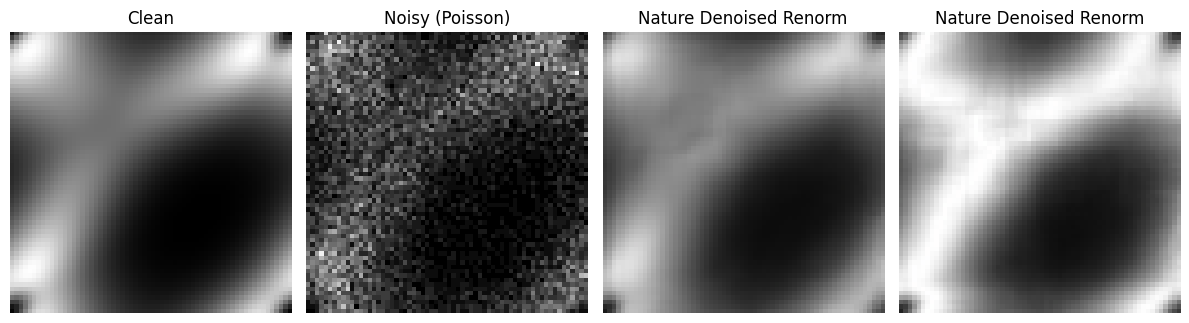

In [25]:


x_noisy = x_test_rgb[0]
x_clean = y_test_rgb[0]

# --- Plot ---
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(ref_d_rgb[0])
axs[0].set_title("Clean")
axs[0].axis("off")

axs[1].imshow(x_noisy)
axs[1].set_title("Noisy (Poisson)")
axs[1].axis("off")
print(x_noisy.shape,"nosie",x_den_test.shape)

axs[2].imshow(x_den_test[0])
axs[2].set_title("Nature Denoised Renorm")
axs[2].axis("off")

def normalize_per_sample(x_rgb):
        max_vals = np.max(x_rgb, axis=(1, 2), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * 1), 0, 1)

#might need to be renormalized because max is no longer 1
renorm_den = normalize_per_sample(x_denoised)
axs[3].imshow(renorm_den)
axs[3].set_title("Nature Denoised Renorm")
axs[3].axis("off")

plt.tight_layout()
plt.show()


In [26]:
print("Pixel sample (0,0):")
print("  Clean      :", x_clean[0,0])
print("  Noisy      :", x_noisy[0,0])
print("  Denoised   :", x_denoised[0,0])
print("  Renormed   :", renorm_den[0,0])

for label, img in zip(["Clean", "Noisy", "Denoised", "Renormed"],
                      [x_clean, x_noisy, np.clip(x_denoised, 0, 1), renorm_den]):
    print(f"{label:<10} max: {np.max(img):.4f}, sum: {np.sum(img):.2f}")


Pixel sample (0,0):
  Clean      : [0.125 0.125 0.125]
  Noisy      : [0.04761905 0.04761905 0.04761905]
  Denoised   : [0.21148904 0.2114392  0.21149452]
  Renormed   : [0.27547964 0.27541474 0.27548677]
Clean      max: 1.0000, sum: 4299.60
Noisy      max: 1.0000, sum: 2516.14
Denoised   max: 0.8123, sum: 4345.17
Renormed   max: 1.0000, sum: 6979.03


In [29]:
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)

In [30]:
# --- Evaluation ---
print("\n>>> Evaluation Metrics on BM3D Denoised Image")

# 2-norm difference (before/after renorm)
norm_original = np.linalg.norm(x_denoised - x_clean)
norm_renormed = np.linalg.norm(renorm_den - x_clean)

print(f"2-norm (x_denoised vs ref_d_rgb): {norm_original:.4f}")
print(f"2-norm (renormalized vs ref_d_rgb): {norm_renormed:.4f}")

# Jensen-Shannon divergence setup
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence

jsd_noisy = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_noisy, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_original = jensen_shannon_divergence_loss(tf.convert_to_tensor(x_denoised, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
jsd_renormed = jensen_shannon_divergence_loss(tf.convert_to_tensor(renorm_den, dtype=tf.float32),
                                               tf.convert_to_tensor(x_clean, dtype=tf.float32))
print(f"JSD (x_noisy vs ref_d_rgb): {jsd_noisy.numpy():.6f}")
print(f"JSD (x_denoised vs ref_d_rgb): {jsd_original.numpy():.6f}")
print(f"JSD (renormalized vs ref_d_rgb): {jsd_renormed.numpy():.6f}")


>>> Evaluation Metrics on BM3D Denoised Image
2-norm (x_denoised vs ref_d_rgb): 7.2029
2-norm (renormalized vs ref_d_rgb): 29.7510
JSD (x_noisy vs ref_d_rgb): 0.041275
JSD (x_denoised vs ref_d_rgb): 0.004962
JSD (renormalized vs ref_d_rgb): 0.004962


In [37]:
A=decode_rgb_to_voxel_batch(x_test_rgb,'scalers/x_test_scalers.npz')

In [38]:
print(A.shape)

(10, 64, 64, 64)


In [39]:
print(x_test_rgb.shape)

(640, 64, 64, 3)
